In [2]:
import matplotlib as mpl #画图用的库
import matplotlib.pyplot as plt
#下面这一句是为了可以在notebook中画图
%matplotlib inline
import numpy as np
import sklearn   #机器学习算法库
import pandas as pd #处理数据的库   
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras   #使用tensorflow中的keras
#import keras #单纯的使用keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, sklearn, pd, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.0
sklearn 0.22
pandas 0.25.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [3]:
#引用位于sklearn数据集中的房价预测数据集
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR) #数据集的描述
print(housing.data.shape) #相当于 x
print(housing.target.shape) #相当于 y

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [4]:
#查看当前x、y的数据类型

import pprint #pprint()模块打印出来的数据结构更加完整,对于数据结构比较复杂、数据长度较长的数据，适合采用pprint()

pprint.pprint(housing.data[0:5])
pprint.pprint(housing.target[0:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
array([4.526, 3.585, 3.521, 3.413, 3.422])


In [5]:
#用sklearn中专门用于划分训练集和测试集的方法
from sklearn.model_selection import train_test_split

#train_test_split默认将数据划分为3:1，我们可以通过修改test_size值来改变数据划分比例(默认0.25，即3:1)
#将总数乘以test_size就表示test测试集、valid验证集数量
#将数据集整体拆分为train_all和test数据集
x_train_all,x_test, y_train_all,y_test = train_test_split(housing.data, housing.target, random_state=7)
#将train_all数据集拆分为train训练集和valid验证集
x_train,x_valid, y_train,y_valid = train_test_split(x_train_all, y_train_all, random_state=11)

print(x_train_all.shape,y_train_all.shape)
print(x_test.shape, y_test.shape)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(15480, 8) (15480,)
(5160, 8) (5160,)
(11610, 8) (11610,)
(3870, 8) (3870,)


In [6]:
#训练数据归一化处理
# x = (x - u)/std  u为均值，std为方差
from sklearn.preprocessing import StandardScaler #使用sklearn中的StandardScaler实现训练数据归一化

scaler = StandardScaler()#初始化一个scaler对象
x_train_scaler = scaler.fit_transform(x_train)#x_train已经是二维数据了，无需astype转换
x_valid_scaler = scaler.transform(x_valid)
x_test_scaler  = scaler.transform(x_test)

In [7]:
#tf.keras.models.Sequential()建立模型

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu",input_shape=x_train.shape[1:]),
    keras.layers.Dense(1),
])
#编译model。 loss目标函数为均方差，这里表面上是字符串，实际上tensorflow中会映射到对应的算法函数，我们也可以自定义
model.compile(loss="mean_squared_error", optimizer="adam")

In [11]:
#查看model有多少层
model.layers

In [12]:
#查看model的架构
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [15]:
#使用监听模型训练过程中的callbacks

logdir='./callbacks_regression'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,"regression_california_housing.h5")

#首先定义一个callback数组
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3)
]

history=model.fit(x_train_scaler,y_train,epochs=100,
                 validation_data=(x_valid_scaler,y_valid),
                 callbacks=callbacks)


Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 164us/sample - loss: 1.9563 - val_loss: 0.8091
Epoch 2/100
11610/11610 [==============================] - 1s 59us/sample - loss: 0.6244 - val_loss: 0.5893
Epoch 3/100
11610/11610 [==============================] - 1s 58us/sample - loss: 0.4935 - val_loss: 0.4895
Epoch 4/100
11610/11610 [==============================] - 1s 58us/sample - loss: 0.4372 - val_loss: 0.4474
Epoch 5/100
11610/11610 [==============================] - 1s 60us/sample - loss: 0.4160 - val_loss: 0.4305
Epoch 6/100
11610/11610 [==============================] - 1s 63us/sample - loss: 0.4050 - val_loss: 0.4179
Epoch 7/100
11610/11610 [==============================] - 1s 64us/sample - loss: 0.3945 - val_loss: 0.4085
Epoch 8/100
11610/11610 [==============================] - 1s 60us/sample - loss: 0.3878 - val_loss: 0.4033
Epoch 9/100
11610/11610 [==============================] - 1s 53us/sample - loss: 0.38

In [16]:
history.history

{'loss': [1.9563441457879842,
  0.6243991155135642,
  0.4934931800655,
  0.4372108625965217,
  0.41597256665595334,
  0.4050065700397935,
  0.39454149274760336,
  0.38783678490472806,
  0.38272940540857914,
  0.3756500534873703,
  0.37573072882585745,
  0.36735981062093137,
  0.36228619856530486,
  0.35889675624405487,
  0.35838025340635543,
  0.35107615890685695,
  0.34734657013549775,
  0.3453796810933375,
  0.34300374399475964,
  0.34379391600405934,
  0.33769980981933156,
  0.33282968518448536,
  0.3324350869624806,
  0.32965434966263946,
  0.3314865024822935,
  0.33321783824741175,
  0.3259863092250397,
  0.32543385721916374,
  0.3211014141716082,
  0.3214884898253908,
  0.3216664831202981,
  0.3183314632768779,
  0.3202132869752495,
  0.3162856487186688,
  0.31703923751474145,
  0.31641623948946995,
  0.31514984791285,
  0.31531773362562227,
  0.31190563917776104,
  0.3116792381785226,
  0.3171047783688571,
  0.3121862380438894,
  0.3101756076531406,
  0.3136022649352454,
  0.308

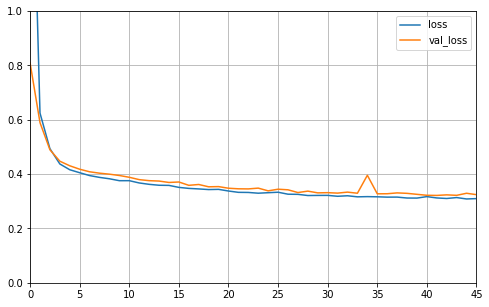

In [17]:
#打印模型训练过程中的相关曲线
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
plot_learning_curves(history)

In [18]:
model.evaluate(x_test_scaler,y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.33584680608076645